# Sentiment Analysis: Large Movie Review Dataset

Hi again! You will be expected to finish this on your own, but you can use the available channels on Discord to ask questions and help others. Please read the entire notebook before starting, this will give you a better idea of what you need to accomplish.

This project is related to NLP. As you may already know, the most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files:

- `movies_review_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `movies_review_test_aai.csv`: Test dataset to test your model.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [1]:
from src import data_utils
import os
import sys
import numpy as np
from gensim.models import Word2Vec
import nltk

sys.path.append(os.path.dirname(os.getcwd()))

from src import word2vec
from src import evaluation
from src import text_normalizer

np.random.seed(42)

train, test = data_utils.get_datasets()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cecilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cecilia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# TODO Complete in this cell: Complete the function `split_data()` but not here in
# the notebook, do it in the python module called `data_utils.py`.
# Then make sure this code runs without errors.
X_train, y_train, X_test, y_test = data_utils.split_data(train, test)

---
## 2. Normalize the data

**Create the following functions but not here in the notebook, do it in the python script called `text_normalizer.py` and import them into the notebook (this way you can build your own NLP preprocessing library). In fact, the structure of the functions is already written, you must complete them with the code that you consider necessary.**

- `remove_html_tags(text):` to remove all HTML tags that may be present in text.
- `remove_accented_chars(text):` to remove accented characters from text
- `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
- `lemmatize_text(text):` to lemmatize text.
- `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
- `remove_special_chars(text):` to remove special characters from text.
- `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
- `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
- `remove_extra_new_lines(text):` to remove extra newlines from text.
- `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.

To apply each of the functions you created and pre-process the dataset, you must use the `normalize_corpus()` function of the `text_normalizer.py` script. In this method each of the functions you wrote is called, in fact you must enable or disable what you consider necessary (at this point we leave it to your free choice, for example, you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest, but that is your choice), this function simply groups the previous ones for a more simplified use.

In [3]:
stop_words = nltk.corpus.stopwords.words("english")

In [4]:
# TODO: Complete all the functions with the `TODO` comment inside the
# module `text_normalizer.py`. Then make sure this code runs without errors.
# You can change the parameters for `normalize_corpus()` if you want.
# norm_train_reviews -> text_normalizer.normalize_corpus(X_train, stopwords=stop_words)
# norm_test_reviews -> text_normalizer.normalize_corpus(X_test, stopwords=stop_words)

# Normalizer with multi-processing
from concurrent.futures import ProcessPoolExecutor
import itertools
from functools import partial

# The amount of chunks to split the data into
chunks = 8
chunk_size = len(X_train) // chunks
executor = ProcessPoolExecutor(max_workers=8)

# partial from functools allows us to create a function with a subset of the arguments
normalize = partial(text_normalizer.normalize_corpus, stopwords=stop_words)

# split the data into chunks and apply the function in parallel
train_temp = list(executor.map(normalize, np.array_split(X_train, chunks)))

# flatten list of lists
norm_train_reviews = list(itertools.chain(*train_temp))

# split the data into chunks and apply the function in parallel
test_temp = list(executor.map(normalize, np.array_split(X_test, chunks)))

# flatten list of lists
norm_test_reviews = list(itertools.chain(*test_temp))

**(\*) Functions will be checked using unit tests.**

---
## 3. Feature Engineering

You already have the pre-processed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.


In [5]:
# TODO Complete in this cell: Use BoW or TF-IDF to vectorize your data.
# Remember to call the `fit()` method only on the train dataset!
# Assign the features to the variables `train_features` and `test_features`.

from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Use the vectorizer to fit and transform the documents
train_features = tfidf_vectorizer.fit_transform(norm_train_reviews)
test_features = tfidf_vectorizer.transform(norm_test_reviews)

print("Train:",train_features.get_shape())
print("Test:",test_features.get_shape())

Train: (25000, 136828)
Test: (25000, 136828)


## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

**In addition to training the model we ask you to show:**

- `Precision`
- `Recall`
- `F1-Score`
- `Classification Report`
- `Confusion Matrix`

**To do this you must complete the `get_performance` function of the `evaluation.py` script.**

**Also, you must complete the `plot_roc` function so that it can show:**

- `ROC Curve`
- `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [6]:
%%time
# TODO Complete in this cell: Create and train your own model.
# Having the model trained, use it to make predictions on the test dataset.
# Assign the predictions to the variable `model_predictions`, it will be used in the
# following cell to evaluate the model performance.

from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(C=0.1)

baseline_model.fit(train_features, y_train)
model_predictions = baseline_model.predict(test_features)

CPU times: total: 281 ms
Wall time: 1.57 s


In [7]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    model_predictions, y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.85612
Precision: 0.8405109768224585
Recall: 0.87904
F1 Score: 0.8593438392054119

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.84      0.88      0.86     12500
           0       0.87      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10415   2085
1   1512  10988


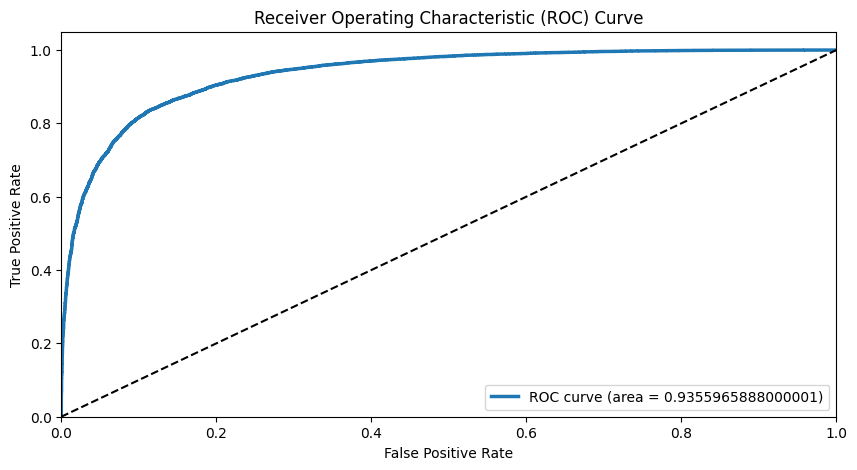

0.9355965888000001

In [8]:
evaluation.plot_roc(baseline_model, y_test, test_features)

---

## 5. Classifying using K-Means

Let use tfidf features computed in last section as vector inputs for kmeans.

In [45]:
# TODO Complete in this cell: Train the k-means clustering model using `n_clusters=2`.
# Having the model trained, use it to make predictions on the test dataset.
# Assign the predictions to the variable `kmeans_predictions`, it will be used in the
# following cell to evaluate the model performance.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init='auto')

kmeans.fit(train_features)
print(f"Converged after {kmeans.n_iter_} iterations")
kmeans_predictions = kmeans.predict(test_features)

Converged after 29 iterations


In [46]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    [1 - el for el in kmeans_predictions], y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.5746
Precision: 0.5528119159540126
Recall: 0.78088
F1 Score: 0.6473455582451836

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.55      0.78      0.65     12500
           0       0.63      0.37      0.46     12500

    accuracy                           0.57     25000
   macro avg       0.59      0.57      0.56     25000
weighted avg       0.59      0.57      0.56     25000


Prediction Confusion Matrix:
------------------------------
      0     1
0  4604  7896
1  2739  9761


---
## 6. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [9]:
# TODO Complete in this cell: Tokenize your text corpus and use them to train
# a Word2Vec model.

from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

# TODO: Create and store here the tokenized train and test data.
tokenized_train = [tokenizer.tokenize(review) for review in norm_train_reviews] 
tokenized_test = [tokenizer.tokenize(review) for review in norm_test_reviews] 

# TODO: Train your Word2Vec model and assign it to `model_w2v`.
# The output model vector size (w2v_vector_size) is set by default to 100,
# you can change it if you want.
w2v_vector_size = 100
model_w2v =  Word2Vec(sentences=tokenized_train, 
                      vector_size=w2v_vector_size, 
                      min_count=5, workers=8,
                      window=10, sg=0, hs=1) 


### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

To do this you must complete the `vectorize` function of the `word2vec.py` module.

In [47]:
# TODO: Make sure you have completed the `vectorizer()` function from
# word2vec.py module.
# You don't need to change this code, just make it run without errors.
w2v_train_features = word2vec.vectorizer(
    corpus=tokenized_train, model=model_w2v, num_features=w2v_vector_size
)
w2v_test_features = word2vec.vectorizer(
    corpus=tokenized_test, model=model_w2v, num_features=w2v_vector_size
)


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [48]:
# TODO Complete in this cell: Train and choose the best model for the task.
# Assign this model to the `best_model` variable.

best_model = LogisticRegression(C=0.1) 

best_model.fit(w2v_train_features, y_train)
best_model_predictions = best_model.predict(w2v_test_features)


In [49]:
# the model performance.
accuracy, precision, recall, f1_score = evaluation.get_performance(
    best_model_predictions, y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.86556
Precision: 0.8659991990388466
Recall: 0.86496
F1 Score: 0.8654792875725434

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.87      0.86      0.87     12500
           0       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10827   1673
1   1688  10812


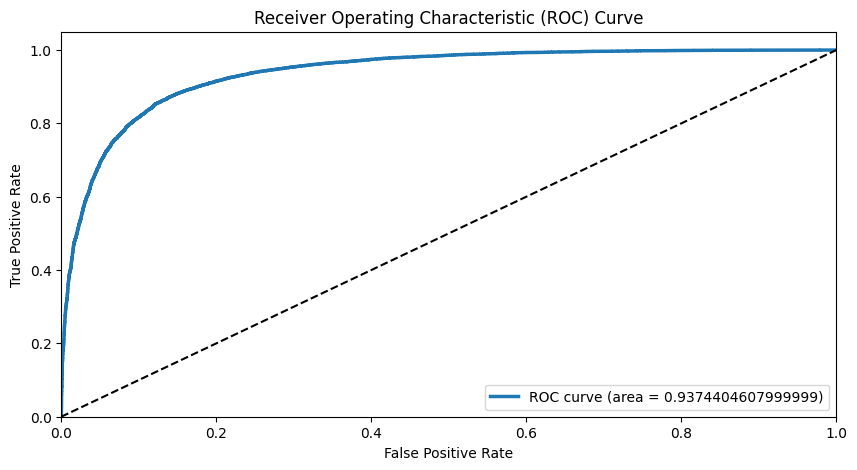

0.9374404607999999

In [52]:
# TODO: Use the `plot_roc()` function from `evaluation.py` module to show
# the model ROC curve.
evaluation.plot_roc(best_model, y_test, w2v_test_features)

## 7. Predict data

- Take your best model
- Take `test data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `positive` column in the `test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
- You will have to use that model to fill values in the positive column using the model predictions
- Save the modified version of the DataFrame with the name (`dataset/movies_review_predict_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code.

Let's say your best model is called `logistic_word2vec`, then your code should be exactly this:

```python
    from src import config
    from pathlib import Path
    DATASET_TEST_PREDICT = str(Path(config.DATASET_ROOT_PATH) / "movies_review_predict_aai.csv")
    test_preds = logistic_word2vec.predict_proba(w2v_test_features)[:, 1]
    test["positive"] = test_preds
    test.to_csv(DATASET_TEST_PREDICT, index=False)
```

In [53]:
# TODO
from src import config
from pathlib import Path

DATASET_TEST_PREDICT = str(Path(config.DATASET_ROOT_PATH) / "movies_review_predict_aai.csv")
test_preds = best_model.predict_proba(w2v_test_features)[:, 1]
test["positive"] = test_preds
test.to_csv(DATASET_TEST_PREDICT, index=False)

---
### OPTIONAL:

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not the case with our problem). Therefore, we invite you to investigate and use one of the `pre-trained Word2Vec models`.

If you look for the `Pretrained models` section in this [link](https://radimrehurek.com/gensim/models/word2vec.html), you will find information about the models that Gensim owns.

In [37]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

# Download the "glove-twitter-100" embeddings
pretrained_w2v = gensim.downloader.load('glove-twitter-100')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [39]:
# Define a function to convert a list of tokens into a matrix of word vectors
def tokenized_to_vectors(tokenized_text, model):
    vectors = []
    for tokens in tokenized_text:
        # Generate a vector for each token and append it to the list of vectors
        word_vectors = [model.get_vector(word) for word in tokens if word in model.key_to_index]
        # If there are no word vectors for the tokens, append a zero vector
        if len(word_vectors) == 0:
            vectors.append(np.zeros(model.vector_size))
        else:
            vectors.append(np.mean(word_vectors, axis=0)) # average of the word vectors
    return np.array(vectors)

# Vectorize the list of tokenized movie reviews
w2v_train_features = tokenized_to_vectors(tokenized_train, pretrained_w2v)
w2v_test_features = tokenized_to_vectors(tokenized_test, pretrained_w2v)

In [40]:
optative_best_model = LogisticRegression(C=0.1) 

optative_best_model.fit(w2v_train_features, y_train)
optative_best_model_predictions = optative_best_model.predict(w2v_test_features)

accuracy, precision, recall, f1_score = evaluation.get_performance(
    best_model_predictions, y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.86556
Precision: 0.8659991990388466
Recall: 0.86496
F1 Score: 0.8654792875725434

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.87      0.86      0.87     12500
           0       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10827   1673
1   1688  10812


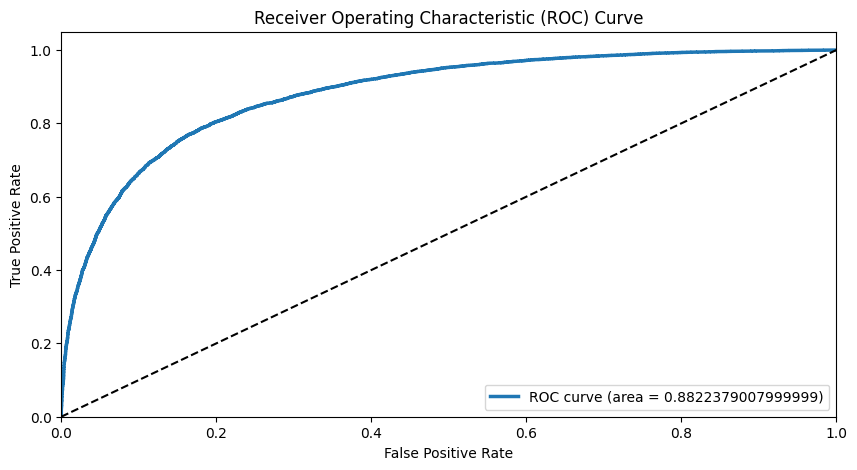

0.8822379007999999

In [41]:
# the model ROC curve.
evaluation.plot_roc(optative_best_model, y_test, w2v_test_features)